# TP - Parte 2
#### Análisis de datos sobre dataset ["Crímenes reportados en Chicago", año 2024](https://data.cityofchicago.org/Public-Safety/Crimes-2024/dqcy-ctma/about_data) -- Continuación --
#### 

### Consignas
El análisis debe abordar los siguientes aspectos:
 * Análisis de balance/desbalance de clases ante un posible problema de clasificación.
    * Plantear/describir el problema y analizar la variable target.
    * Proponer y aplicar mecanismos de balance en caso de ser necesario y justificar la selección.
 * Análisis y selección de features:
    * Implementar tests estadísticos para evaluar relaciones entre features.
    * Realizar una selección de variables basándose en su relevancia y significancia.
    * Justificar la elección de las variables seleccionadas.
    * Crear nuevos features en caso de ser necesario. Justificar.
 * Transformación de variables:
    * Aplicar técnicas de conversión de variables, por ejemplo: codificación, discretización.
    * Escalar y / o normalizar los features.
 * Reducción de la dimensionalidad:
    * Implementar dos técnicas de reducción de la dimensionalidad. Comparar.
    * Comparar el dataset original con el dataset reducido, evaluando las ventajas y desventajas de la reducción.
    * Analizar cómo la reducción de la dimensionalidad afecta la interpretación y el rendimiento de futuros modelos predictivos.

#### Integrantes:
* Mealla Pablo
* Viñas Gustavo

In [1]:
# Import de librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
sns.set_theme()

### Cargamos el dataset analizado en la parte 1

In [2]:
# Carga del dataset
df_csv = pd.read_parquet("dataset/tp1.parquet", engine="fastparquet")

# Análisis inicial de columnas y cantidad de datos, para comparar y estar seguros que el dataset se cargó correctamente
df_csv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 256840 entries, 13709672 to 13656417
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Date                  256840 non-null  datetime64[ns]
 1   IUCR                  256840 non-null  category      
 2   Primary Type          256840 non-null  category      
 3   Description           256840 non-null  category      
 4   Location Description  256840 non-null  category      
 5   Arrest                256840 non-null  int64         
 6   Domestic              256840 non-null  int64         
 7   Beat                  256840 non-null  category      
 8   District              256840 non-null  category      
 9   Ward                  256840 non-null  category      
 10  Community Area        256840 non-null  category      
 11  FBI Code              256840 non-null  category      
 12  Latitude              256840 non-null  float64       


In [3]:
# Como en la parte 1 realizamos modificaciones para el EDA, algunas las volvemos al formato original del dataset
df_csv["Arrest"] = df_csv["Arrest"].astype(bool).astype('category')
df_csv["Domestic"] = df_csv["Domestic"].astype(bool).astype('category')

### Variable target: FBI Code  
En este dataset planteamos como objetivo obtener el código de crimen del FBI a partir de los datos del crimen de la policía de Chicago.  
De esta forma, todas las features son datos ingresados por la policía de Chicago, y el target es una correspondencia con el código que utiliza el FBI, dato que desconocemos.

### Análisis de desbalances
Analizamos el desbalance entre categorías del target

In [4]:
target = 'FBI Code'

# Primero separamos los features y el target
X = df_csv.drop(columns=[target])
y = df_csv[target]

Recordemos como se observa gráficamente la distribución y desbalance en FBI CODE:

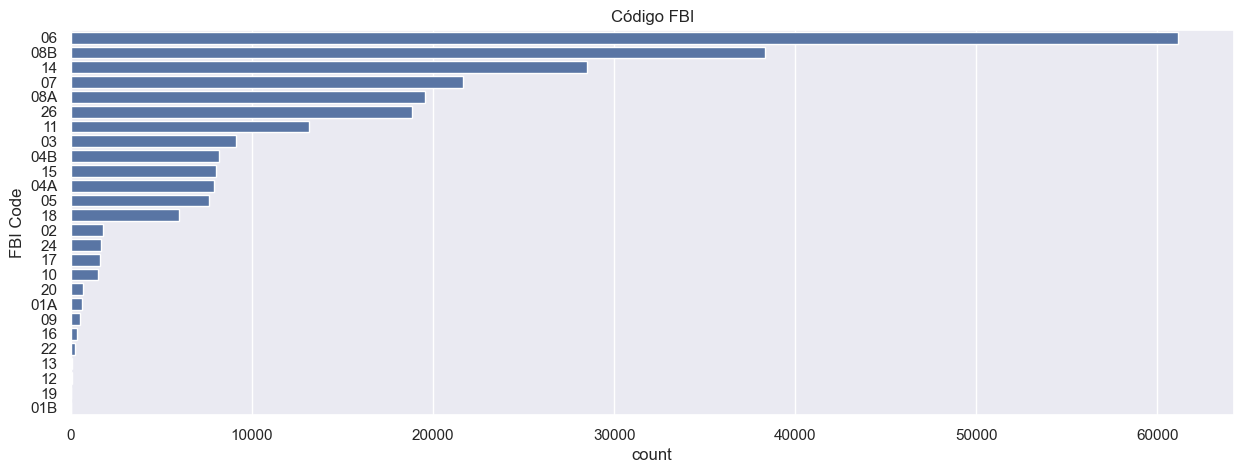

In [5]:
# Graficamos la distribución de FBI Code

fig, ax = plt.subplots(figsize=(15, 5))
sns.countplot(data=y, order=y.value_counts().index, ax=ax)
ax.set_title('Código FBI')
plt.show()

<span style="color:red"> **** Observamos la Matriz de confusión: ****</span>

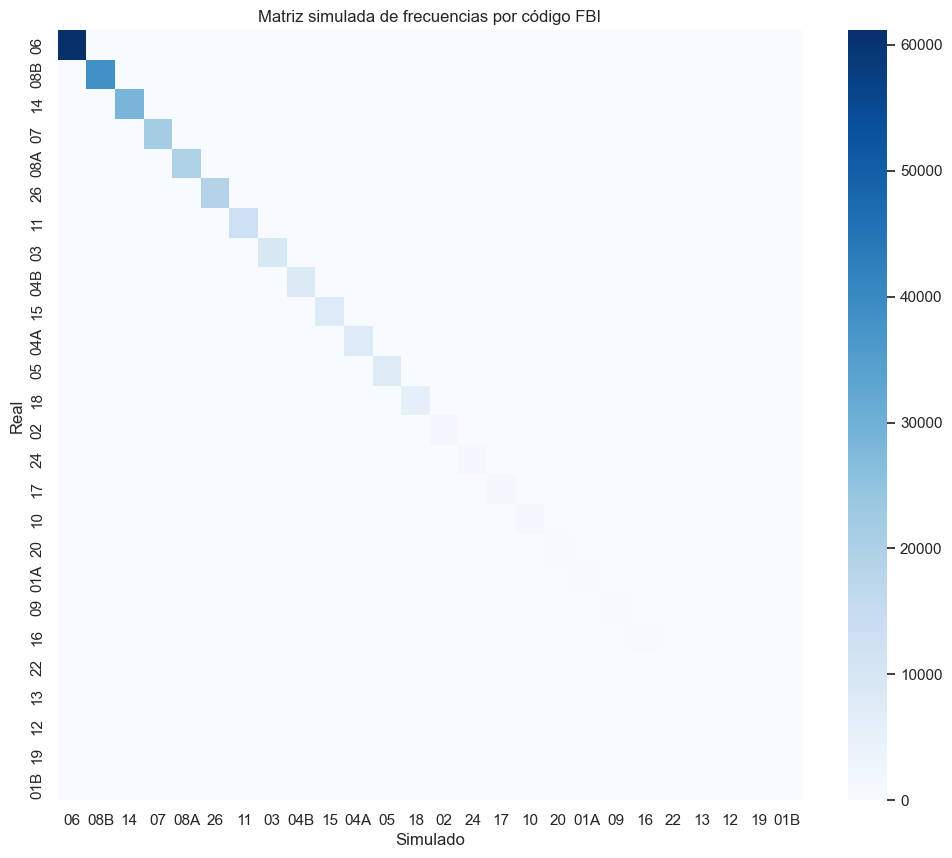

In [6]:
# Contar ocurrencias por clase
counts = df_csv['FBI Code'].value_counts()

# Crear matriz de confusión simulada
conf_matrix = pd.DataFrame(0, index=counts.index, columns=counts.index)
for code in counts.index:
    conf_matrix.loc[code, code] = counts[code]

# Visualizar con heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=False, fmt="d", cmap="Blues", cbar=True)
plt.title("Matriz simulada de frecuencias por código FBI")
plt.xlabel("Simulado")
plt.ylabel("Real")
plt.show()

#### En la matriz se puede observar cierto desbalance:

* Clases con muchas muestras → cuadros más oscuros en la diagonal.

* Clases raras → cuadros pálidos.

#### Para concluir si realmente el desbalance que observamos requiere un tratamiento, calculamos:
* Indice de Gini
* Entropía de Shannon


In [7]:
# Función auxiliar para mostrar info

def info_categorical(y):
    # Cantidad de categorías
    num_categ = y.nunique()
    print(f"Número de categorías únicas: {num_categ}")

    # Calculamos el porcentaje de cada categoría
    cantidad = y.value_counts()
    proportion = cantidad / cantidad.sum()
    proportion_sum = proportion.cumsum()
    print("Distribución de categorías:")
    with pd.option_context('display.max_columns', None):
        show_df = pd.DataFrame([proportion * 100, proportion_sum * 100, cantidad], index=["Porcentaje", "Acumulado", "Cantidad"])
        display(show_df.round(2))

    # Calculamos el índice de Gini
    gini_index = 1 - sum(proportion**2)
    gini_index_opt = 1 - len(proportion) * ((1/len(proportion))**2)
    print(f"Índice de Gini: {gini_index:.4f}")
    print(f"Índice de Gini óptimo: {gini_index_opt:.4f}")

    # Calculamos entropía de Shannon
    shannon_entropy = -sum(proportion * np.log2(proportion))
    shannon_entropy_max = np.log2(len(proportion))
    print(f"Entropía de Shannon: {shannon_entropy:.4f}")
    print(f"Entropía de Shannon máxima teórica: {shannon_entropy_max:.4f}")

    print(f"Muestras: {y.shape[0]}.")


In [8]:
info_categorical(y)

Número de categorías únicas: 26
Distribución de categorías:


FBI Code,06,08B,14,07,08A,26,11,03,04B,15,04A,05,18,02,24,17,10,20,01A,09,16,22,13,12,19,01B
Porcentaje,23.81,14.92,11.10,8.44,7.61,7.33,5.11,3.55,3.18,3.13,3.07,2.98,2.32,0.68,0.64,0.61,0.58,0.27,0.23,0.19,0.12,0.08,0.02,0.01,0.01,0.0
Acumulado,23.81,38.73,49.83,58.27,65.88,73.22,78.33,81.88,85.07,88.19,91.27,94.24,96.56,97.24,97.89,98.50,99.08,99.34,99.57,99.76,99.88,99.95,99.98,99.99,100.00,100.0
Cantidad,61154.00,38309.00,28520.00,21680.00,19556.00,18837.00,13123.00,9125.00,8179.00,8033.00,7896.00,7645.00,5960.00,1743.00,1649.00,1576.00,1481.00,683.00,585.00,482.00,307.00,196.00,64.00,33.00,22.00,2.0


Índice de Gini: 0.8820
Índice de Gini óptimo: 0.9615
Entropía de Shannon: 3.5200
Entropía de Shannon máxima teórica: 4.7004
Muestras: 256840.


Según los valores observados tanto para el Indice de Gini como para la Entropía de Shannon no es necesario realizar un banlanceo, los valores son relativamente aceptables.


### Creación de features

Consideramos que agregar la estación del año (Season) puede ayudar al modelo sabiendo que los crímenes también están relaciones al clima estacional.

Anteriormente para el TP1 ya se habían agregados los siguientes features para el análisis puntual de crimenes por día y horario:

* "Hour"
* "Day Of Week"
* "Day"
* "Month"
  

In [9]:
# Función para determinar la estación del año
def get_season(date):
    month = date.month
    day = date.day
    
    if (month == 12 and day >= 21) or (month == 1) or (month == 2) or (month == 3 and day < 20):
        return 'Invierno'
    elif (month == 3 and day >= 20) or (month == 4) or (month == 5) or (month == 6 and day < 21):
        return 'Primavera'
    elif (month == 6 and day >= 21) or (month == 7) or (month == 8) or (month == 9 and day < 23):
        return 'Verano'
    else:
        return 'Otoño'

# Aplicar la función para crear la nueva columna "Season"
X['Season'] = X['Date'].apply(get_season).astype('category')

# Verificar el resultado
display(X[['Date', 'Season']].sample(10, random_state=42))


,Date,Season
ID,,
13378149,2024-02-23 18:36:00,Invierno
13662708,2024-11-12 12:20:00,Otoño
13617643,2024-10-01 22:00:00,Otoño
13517331,2024-07-04 03:05:00,Verano
13642735,2024-10-25 19:30:00,Otoño
13678101,2024-11-29 23:30:00,Otoño
13507052,2024-06-17 19:00:00,Primavera
13389085,2024-03-05 14:00:00,Invierno
13436546,2024-04-21 22:19:00,Primavera


In [10]:
# Eliminamos Date, que ya la usamos para agregar otras features, y no aporta más información
X_train = X.drop("Date", axis=1)

#### Antes de continuar con la transformación, debemos separar en train y test

In [11]:
from sklearn.model_selection import train_test_split
# También separamos el set de entrenamiento y el de test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


### Transformación de variables - Encoding

Para empezar el análisis, observamos la cardinalidad de las variables categóricas que queremos codificar


In [12]:
X_train.describe(include="category")

,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,Season
count,205472,205472,205472,205472,205472,205472,205472,205472,205472,205472,205472
unique,331,31,309,125,2,2,275,22,50,77,4
top,0486,THEFT,SIMPLE,STREET,False,False,1834,8,27,25,Verano
freq,16265,48294,25204,55544,177266,167512,2445,13765,9568,10340,57094


In [13]:
numericas = ["Latitude", "Longitude"]
ordinales = [] # No tenemos features ordinales
cardinalidad_baja = ["Arrest", "Domestic", "Day Of Week", "Season"]
cardinalidad_media = ["IUCR", "Primary Type", "Description", "Location Description", "Beat", "District", "Ward", "Community Area", "Hour", "Day", "Month"]

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer, MinMaxScaler
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder

# En nuestro dataset no quedaron nulos, pero definimos imputaciones por si acaso vinieran nulos

# Convierte el dato en string
def to_str(X):
    return X.astype(str)

transformar_numericas = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

# No tenemos ordinales, pero podríamos usar la siguiente transformación si hubiera
transformar_ordinales = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('scaler', StandardScaler())
])

transformar_bajacard = Pipeline(steps=[
    ('to_str', FunctionTransformer(to_str, validate=False)), # Para que no falle con categoricas string
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))  # drop=first para reducir los features
])

transformar_nominales = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target_encoder', TargetEncoder(handle_unknown='value')), # Si se encuentra con una categoría desconocida, codifica con la media global del set de entrenamiento
    ('scaler', MinMaxScaler()),
])

In [15]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformar_numericas, numericas),
        ('ord', transformar_ordinales, ordinales),
        ('bin', transformar_bajacard, cardinalidad_baja),
        ('nom', transformar_nominales, cardinalidad_media)
    ],
    remainder='drop'
)

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Hacemos fit y transform sobre train
X_train_procesado = pipeline.fit_transform(X_train, y_train)

# Vemos como quedó el pipeline
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Latitude', 'Longitude']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('scaler'...
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Arrest', 'Domestic',
                                                   'Day Of Week', 'Season']),
                                                 ('nom',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('target_encoder',
                                                                   TargetEncoder()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['IUCR', 'Primary Type',
                                                   'Description',
                                                   'Location Description',
                                                   'Beat', 'District', 'Ward',
                                                   'Community Area', 'Hour',
                                                   'Day', 'Month'])]))])

In [16]:
# Ahora aplicamos el transform en test
X_test_procesado = pipeline.transform(X_test)

Reconstruimos el dataset para ver que hizo

In [17]:
numericas_salida = numericas # las numéricas transformadas
ordinales_salida = ordinales # las ordinales transformadas
nominales_salida = cardinalidad_media # las categoricas de cardinalidad media transformadas

binarias_salida = pipeline.named_steps['preprocessor'].named_transformers_['bin'].named_steps['onehot'].get_feature_names_out(cardinalidad_baja)

# Armamos los nombres de las variables en orden de acuerdo a la pipeline
transformed_feature_names = (
    list(numericas_salida) +
    list(ordinales_salida) +
    list(binarias_salida) +
    list(nominales_salida) 
)

# Reconstruimos el dataframe procesado
X_train_preproc = pd.DataFrame(X_train_procesado, columns=transformed_feature_names)
X_test_preproc = pd.DataFrame(X_test_procesado, columns=transformed_feature_names)

with pd.option_context('display.max_columns', None):
    display(X_train_preproc.head(10))

,Latitude,Longitude,Arrest_True,Domestic_True,Day Of Week_1,Day Of Week_2,Day Of Week_3,Day Of Week_4,Day Of Week_5,Day Of Week_6,Season_Otoño,Season_Primavera,Season_Verano,IUCR,Primary Type,Description,Location Description,Beat,District,Ward,Community Area,Hour,Day,Month
0,0.873834,0.107783,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.40,0.364373,0.380443,0.724352,0.353580,0.652183,0.834114,0.731991,0.511134,0.252856,0.657399
1,0.560943,0.680642,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.16,0.292415,0.173074,0.560291,0.366060,0.173057,0.611923,0.457176,0.748931,0.597352,0.446530
2,0.447139,0.654182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.00,0.868435,1.000000,0.560291,0.394479,0.389136,0.714278,0.537431,0.471053,0.951068,0.597076
3,0.922154,0.680636,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.28,0.279877,0.280000,0.444490,0.329796,0.340609,0.439450,0.359416,0.748931,0.130780,0.000000
4,0.607300,0.465286,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.20,0.364373,0.169623,0.560291,0.677275,1.000000,1.000000,0.570214,0.471053,0.383253,0.918194
5,0.161634,0.699715,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.64,0.639939,0.652742,0.560291,0.550253,0.699001,0.847092,0.632355,1.000000,0.601559,0.034917
6,0.849286,0.623043,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.28,0.279877,0.280000,0.560291,0.265679,0.010658,0.440278,0.485314,0.979295,0.252856,0.221235
7,0.672706,0.713470,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.52,0.516398,0.520000,0.638374,0.439470,0.133723,0.693110,0.302498,0.392833,0.383253,0.876586
8,0.706480,0.622388,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.36,0.292415,0.380443,0.589287,0.240848,0.000000,0.000000,0.127218,0.510375,0.551826,0.918194
9,0.281383,0.754523,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.52,0.516398,0.520000,0.611691,0.413594,0.557209,0.668092,0.486627,0.542854,0.451245,0.000000


In [18]:

# Variables que queremos analizar
variables_categoricas = [
    'Primary Type', 
    'Description', 
    'Location Description', 
#    'FBI Code', 
    'Season'
]

# Contar categorías únicas
for col in variables_categoricas:
    print(f"{col}: {X_train[col].nunique()} categorías únicas")

Primary Type: 31 categorías únicas
Description: 309 categorías únicas
Location Description: 125 categorías únicas
Season: 4 categorías únicas


#### Según la cardinalidad y el tipo de categoría podemos codificar las variables de la siguiente forma:

* Para las variables "Primary Type", "Description" y "Location Description" elegimos "Frecuency Encoding"
* Para la variable tarjet "FBI Code": Debido a que los modelos de clasificación suvervisada requieren un target numérico, necesitamos codificar el Feature "FBI Code" y elegimos el "Ordinal Encoder"


In [19]:
# Encode para variables "Primary Type", "Description" y "Location Description"

# Frequency Encoding para Primary Type
freq_encoding = df_csv["Primary Type"].value_counts(normalize=True)
df_csv["Primary_Type_Encode"] = df_csv["Primary Type"].map(freq_encoding)

# Frequency Encoding para Description
freq_encoding = df_csv["Description"].value_counts(normalize=True)
df_csv["Description_Encode"] = df_csv["Description"].map(freq_encoding)

# Frequency Encoding para Location Description
freq_encoding = df_csv["Location Description"].value_counts(normalize=True)
df_csv["Location_Description_Encode"] = df_csv["Location Description"].map(freq_encoding)

df_csv.head()


,Date,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,...,FBI Code,Latitude,Longitude,Hour,Day Of Week,Day,Month,Primary_Type_Encode,Description_Encode,Location_Description_Encode
ID,,,,,,,,,,,,,,,,,,,,,
13709672,2024-12-31 23:58:00,1310,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,False,False,332,3,5,...,14,41.771470,-87.590742,23,1,31,12,0.111042,0.047208,0.191380
13707925,2024-12-31 23:56:00,1365,CRIMINAL TRESPASS,TO RESIDENCE,APARTMENT,True,True,223,2,3,...,26,41.808501,-87.616563,23,1,31,12,0.019242,0.004812,0.191380
13708038,2024-12-31 23:55:00,0498,BATTERY,"AGG. DOMESTIC BATTERY - HANDS, FISTS, FEET, SE...",HOTEL / MOTEL,False,True,834,8,18,...,04B,41.752749,-87.741498,23,1,31,12,0.179365,0.003917,0.004867
13709164,2024-12-31 23:53:00,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,321,3,20,...,14,41.774269,-87.599710,23,1,31,12,0.111042,0.061645,0.270779
13707823,2024-12-31 23:50:00,0460,BATTERY,SIMPLE,SIDEWALK,False,False,2531,25,29,...,08B,41.902858,-87.770537,23,1,31,12,0.179365,0.122641,0.053726


In [20]:
#Encode para variable FBI Code

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# Asegurarse que sea tipo string
df_csv['FBI Code'] = df_csv['FBI Code'].astype(str)

# Crear encoder
ordinalencoder = OrdinalEncoder()

# Aplicar ordinal encoding 
df_csv['FBI_Code_encoded'] = ordinalencoder.fit_transform(df_csv[['FBI Code']]).astype(int)


# Mostrar primeros resultados
print(df_csv[['FBI Code', 'FBI_Code_encoded']].head())

#display(df_csv.head())

         FBI Code  FBI_Code_encoded
ID                                 
13709672       14                16
13707925       26                25
13708038      04B                 5
13709164       14                16
13707823      08B                10


In [21]:
# Aplicar la función para crear la nueva columna "Season"
df_csv['Season'] = df_csv['Date'].apply(get_season).astype('category')

# Inicializar codificador
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')


# Aplicar codificación
season_encoded = encoder.fit_transform(df_csv[['Season']])

# Obtener nombres de columnas codificadas
season_cols = encoder.get_feature_names_out(['Season'])

# Crear DataFrame con codificación y unir al original
df_encoded = pd.DataFrame(season_encoded, columns=season_cols, index=df_csv.index)
df_csv = pd.concat([df_csv, df_encoded], axis=1)

# Opcional: eliminar la columna original 'season'
#df.drop(columns=['season'], inplace=True)

# Verificar resultado
print(df_csv.filter(like='Season_').head())

          Season_Invierno  Season_Otoño  Season_Primavera  Season_Verano
ID                                                                      
13709672              1.0           0.0               0.0            0.0
13707925              1.0           0.0               0.0            0.0
13708038              1.0           0.0               0.0            0.0
13709164              1.0           0.0               0.0            0.0
13707823              1.0           0.0               0.0            0.0


In [22]:
display(df_csv.head())

,Date,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,...,Month,Primary_Type_Encode,Description_Encode,Location_Description_Encode,FBI_Code_encoded,Season,Season_Invierno,Season_Otoño,Season_Primavera,Season_Verano
ID,,,,,,,,,,,,,,,,,,,,,
13709672,2024-12-31 23:58:00,1310,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,False,False,332,3,5,...,12,0.111042,0.047208,0.191380,16,Invierno,1.0,0.0,0.0,0.0
13707925,2024-12-31 23:56:00,1365,CRIMINAL TRESPASS,TO RESIDENCE,APARTMENT,True,True,223,2,3,...,12,0.019242,0.004812,0.191380,25,Invierno,1.0,0.0,0.0,0.0
13708038,2024-12-31 23:55:00,0498,BATTERY,"AGG. DOMESTIC BATTERY - HANDS, FISTS, FEET, SE...",HOTEL / MOTEL,False,True,834,8,18,...,12,0.179365,0.003917,0.004867,5,Invierno,1.0,0.0,0.0,0.0
13709164,2024-12-31 23:53:00,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,321,3,20,...,12,0.111042,0.061645,0.270779,16,Invierno,1.0,0.0,0.0,0.0
13707823,2024-12-31 23:50:00,0460,BATTERY,SIMPLE,SIDEWALK,False,False,2531,25,29,...,12,0.179365,0.122641,0.053726,10,Invierno,1.0,0.0,0.0,0.0


### Análisis y selección de features

Analizaremos la relación entre features según correlacion de Pearson, Spearman y Kendall

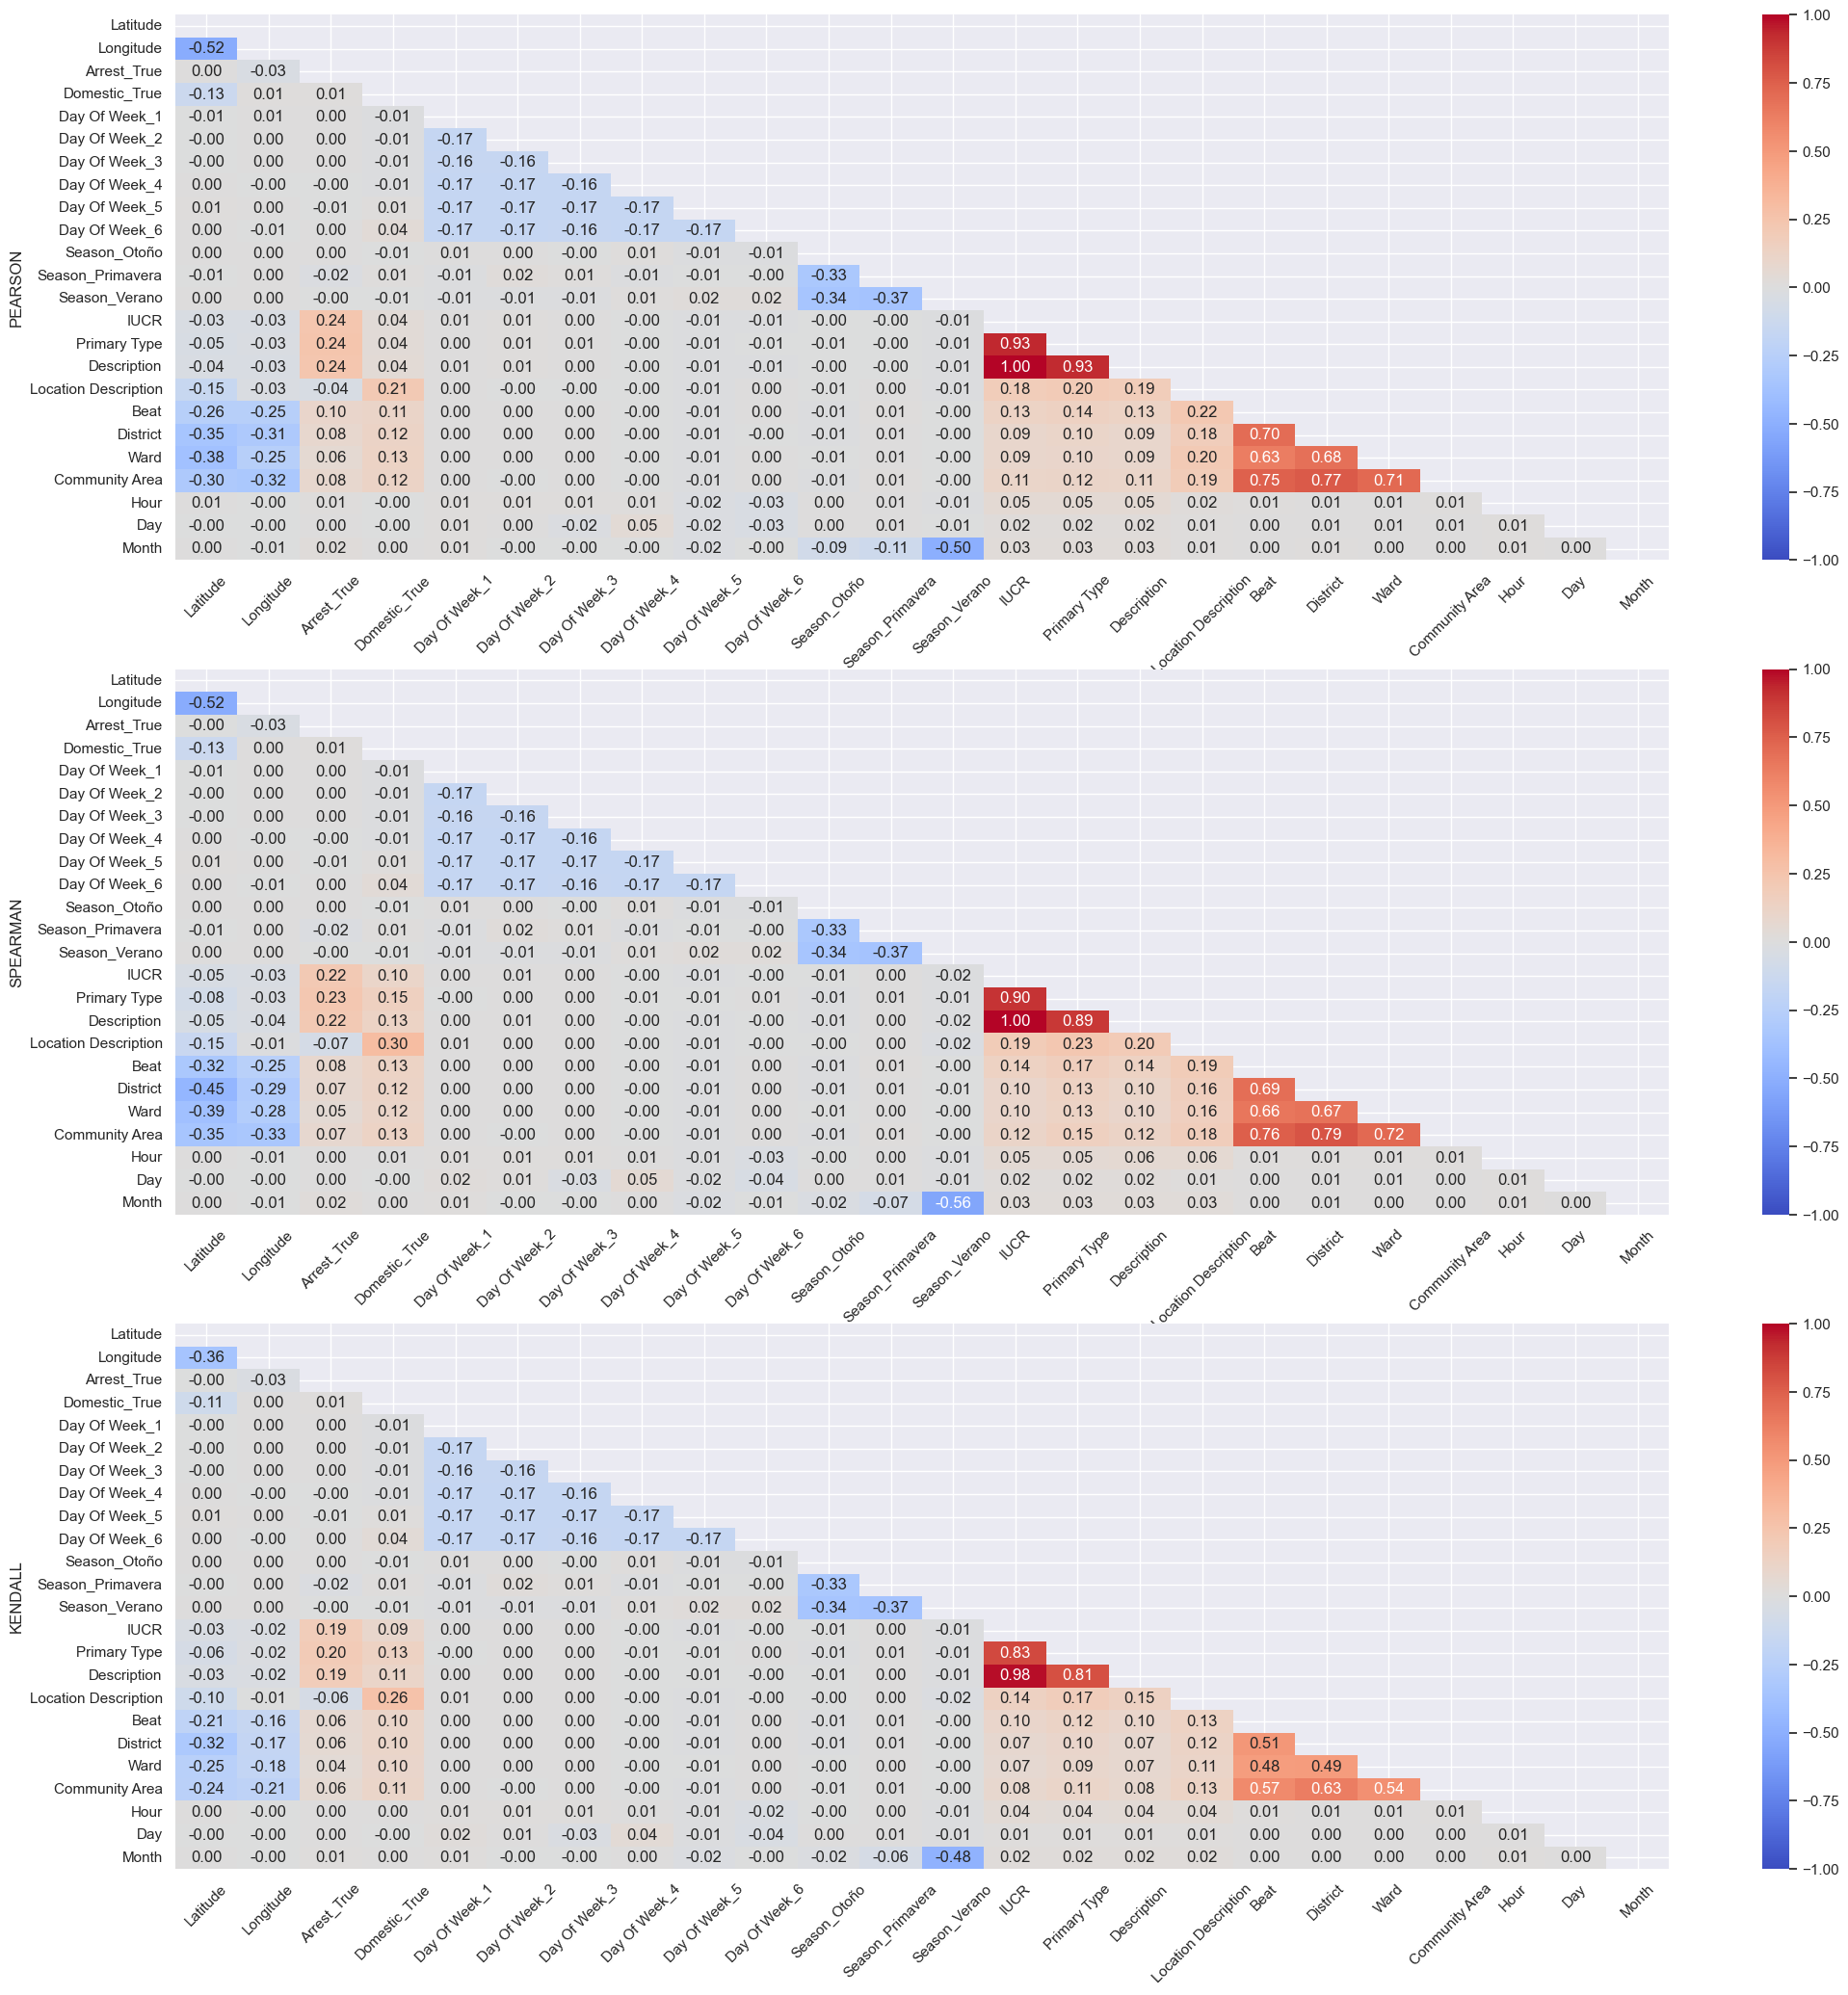

In [23]:
plt.figure(figsize=(25,25))

mask=np.triu(np.ones((len(X_train_preproc.columns), len(X_train_preproc.columns))))

plt.subplot(3, 1, 1)
sns.heatmap(X_train_preproc.corr(numeric_only=False), annot=True, fmt=".2f", cmap="coolwarm",  center=0, vmin=-1, vmax=1, mask=mask)
plt.ylabel('PEARSON')
plt.xticks(rotation=45)

plt.subplot(3, 1, 2)
sns.heatmap(X_train_preproc.corr(method='spearman', numeric_only=False), annot=True, fmt=".2f", cmap="coolwarm", center=0, vmin=-1, vmax=1, mask=mask)
plt.ylabel('SPEARMAN')
plt.xticks(rotation=45)

plt.subplot(3, 1, 3)
sns.heatmap(X_train_preproc.corr(method='kendall', numeric_only=False), annot=True, fmt=".2f", cmap="coolwarm", center=0, vmin=-1, vmax=1, mask=mask)
plt.ylabel('KENDALL')
plt.xticks(rotation=45)

plt.show()


En principio, no hay grandes diferencias entre los 3 métodos.  
Esto se debe a que las relaciones entre variables (si es que las hay), parecen lineales.  
Se ve relación entre Beat/District/Ward/Community Area. Esto se debe a que son datos que estan determinados geográficamente, y tienen áreas comunes.  
Por último, vemos una relación muy fuerte entre IUCR/Primary Type/Description.  
Esto lo sabíamos desde el análisis del origen, ya que son el código, la descripción principal y descripcion detallada del crimen.

#### Umbral de varianza

In [24]:
X_train_preproc.var().sort_values(ascending=False)

Season_Verano           0.200658
Season_Primavera        0.191317
Season_Otoño            0.180350
Domestic_True           0.150615
Day Of Week_5           0.123566
Day Of Week_4           0.123344
Day Of Week_6           0.122213
Day Of Week_1           0.121659
Day Of Week_2           0.121526
Day Of Week_3           0.119804
Arrest_True             0.118431
Month                   0.110568
Day                     0.065725
District                0.056146
IUCR                    0.053255
Description             0.052922
Latitude                0.052690
Hour                    0.052640
Ward                    0.052606
Primary Type            0.047123
Community Area          0.046957
Longitude               0.020656
Beat                    0.016695
Location Description    0.007169
dtype: float64

Si seleccionaramos según la varianza (no tendríamos en cuenta la variable target)

In [25]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.05)
X_train_varthre = selector.fit_transform(X_train_preproc)
print("\nCaracterísticas seleccionadas (varianza):", X_train_preproc.columns[selector.get_support()].tolist())

# Aplico la selección también a test
X_test_varthre = selector.transform(X_test_preproc)


Características seleccionadas (varianza): ['Latitude', 'Arrest_True', 'Domestic_True', 'Day Of Week_1', 'Day Of Week_2', 'Day Of Week_3', 'Day Of Week_4', 'Day Of Week_5', 'Day Of Week_6', 'Season_Otoño', 'Season_Primavera', 'Season_Verano', 'IUCR', 'Description', 'District', 'Ward', 'Hour', 'Day', 'Month']


#### ANOVA
Analizamos el poder predictivo que tienen las features sobre la variable target.


In [26]:
from sklearn.feature_selection import SelectKBest, f_classif

# Como hicimos preprocesamiento, todas nuestras variables son numéricas
selector_anova = SelectKBest(score_func=f_classif, k=3)
X_train_num_best = selector_anova.fit_transform(X_train_preproc, y_train)
selected_indices = selector_anova.get_support()
selected_features = X_train_preproc.columns[selected_indices]
scores = selector_anova.scores_[selected_indices]
print(f"Numéricas antes de filtrar: {X_train_preproc.columns}")
print("\nCaracterísticas seleccionadas (ANOVA):")
for feature, score in sorted(zip(selected_features, scores), reverse=True, key=lambda pair: pair[1]):
    print(f"{feature}: {score:.4f}")

# Aplicamos a los datos de test
X_test_num_best = selector_anova.transform(X_test_preproc)

Numéricas antes de filtrar: Index(['Latitude', 'Longitude', 'Arrest_True', 'Domestic_True',
       'Day Of Week_1', 'Day Of Week_2', 'Day Of Week_3', 'Day Of Week_4',
       'Day Of Week_5', 'Day Of Week_6', 'Season_Otoño', 'Season_Primavera',
       'Season_Verano', 'IUCR', 'Primary Type', 'Description',
       'Location Description', 'Beat', 'District', 'Ward', 'Community Area',
       'Hour', 'Day', 'Month'],
      dtype='object')

Características seleccionadas (ANOVA):
IUCR: 1292917.3624
Description: 685968.1896
Primary Type: 79540.9862


Con ANOVA empezamos a ver lo que esperabamos.  
La feature IUCR es la que mejor score obtuvo, seguida por Description y por último Primary Type.  
Esto quiere decir que el código FBI esta fuertemente relacionado con estas 3 features.

#### Chi-cuadrado
Identificamos la relación entre las categóricas de entrada y la variable categórica de salida


In [27]:
from sklearn.feature_selection import chi2

selector_chi2 = SelectKBest(score_func=chi2, k=5)
X_train_cat_best = selector_chi2.fit_transform(X_train_preproc[cardinalidad_media], y_train)
selected_indices = selector_chi2.get_support()
selected_features = X_train_preproc[cardinalidad_media].columns[selected_indices]
scores = selector_chi2.scores_[selected_indices]
print("\nCaracterísticas seleccionadas (Chi-Square):")
for feature, score in sorted(zip(selected_features, scores), reverse=True, key=lambda pair: pair[1]):
    print(f"{feature}: {score:.4f}")

# Aplicamos a los datos de test
X_test_cat_best = selector_chi2.transform(X_test_preproc[cardinalidad_media])


Características seleccionadas (Chi-Square):
IUCR: 25143.5560
Description: 24850.3499
Primary Type: 20255.6859
District: 1480.7056
Community Area: 1049.0217


Si nos basaramos solo en features categóricas (la mayoría en nuestro caso), obtendríamos un resultado parecido a ANOVA.  
Nuestra selección sería (ordenada de mayor a menor score): IUCR, Description, Primary Type, y con score mucho menor seguirían, District y Community Area.

#### Información Mutua
Por último, analizaremos la relación entre las features y la variable target.

In [28]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

selector_mic = SelectKBest(score_func=mutual_info_classif, k=10)
X_train_inf_mut = selector_mic.fit_transform(X_train_preproc, y_train)

selected_indices = selector_mic.get_support()
selected_features = X_train_preproc.columns[selected_indices]
scores = selector_mic.scores_[selected_indices]
print("\nCaracterísticas seleccionadas (Inf. mutua):")
for feature, score in sorted(zip(selected_features, scores), reverse=True, key=lambda pair: pair[1]):
    print(f"{feature}: {score:.4f}")

# Aplicamos a los datos de test
X_test_inf_mut = selector_mic.transform(X_test_preproc)


Características seleccionadas (Inf. mutua):
IUCR: 2.4436
Description: 2.3141
Primary Type: 2.2259
Location Description: 0.2883
Latitude: 0.1982
Longitude: 0.1874
Domestic_True: 0.1276
Arrest_True: 0.1025
Beat: 0.0897
Community Area: 0.0682


Nuevamente observamos que las 3 features principales son IUCR, Description y Primary Type. Le siguen 7 features mas, pero con bajo score.

Con el análisis realizado, podemos concluir que las features que debemos seleccionar son IUCR, Description y Primary Type, ya que definen el FBI Code (target).  
En todos los casos obtuvieron un score superior al resto de las features.  

### Extracción de features

##### Principal Component Analysis (PCA)

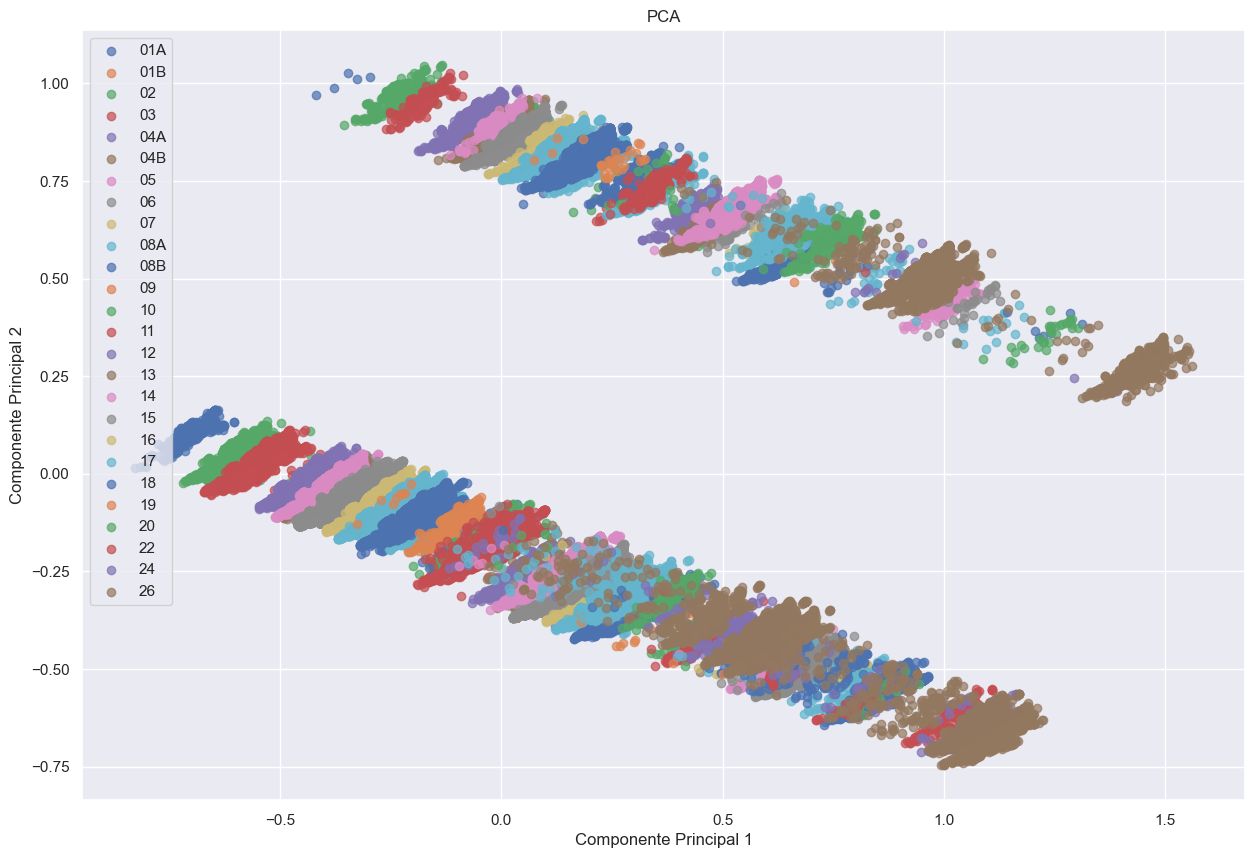

Porcentaje de varianza explicada por cada componente:
[0.30831237 0.26615185 0.17257456 0.12069679]
Porcentaje de varianza acumulada:
[0.30831237 0.57446423 0.74703879 0.86773558]


In [29]:
from sklearn.decomposition import PCA

target_names = y.cat.categories

pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train_inf_mut)

plt.figure(figsize=(15, 10))
for _, target_name in enumerate(target_names):
    plt.scatter(X_train_pca[y_train == target_name, 0], X_train_pca[y_train == target_name, 1], label=target_name, alpha=0.7)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend()
plt.title("PCA")
plt.show()

print(f"Porcentaje de varianza explicada por cada componente:\n{pca.explained_variance_ratio_}")
print(f"Porcentaje de varianza acumulada:\n{np.cumsum(pca.explained_variance_ratio_)}")

# Aplicamos a los datos de test
X_test_pca = pca.transform(X_test_inf_mut)


##### Silhouette Score

Qué tan bien separadas están las clases:
- Cercano a 1: Las clases están bien separadas.
- Cerca de 0: Hay solapamiento entre clases.
- Negativo: Los puntos están mal asignados a grupos.

In [30]:
from sklearn.metrics import silhouette_score
# Calculamos solo sobre el 10% porque demora mucho si usamos todas las muestras
sil_score = silhouette_score(X_train_pca, y_train, sample_size=int(len(X_train_pca)*0.1), random_state=42)
print(f"Silhouette Score: {sil_score:.2f}")

Silhouette Score: -0.12


Para PCA vemos que el resultado es muy malo, el score da negativo.  
Se ve tambien en el gráfico que no hay una separación clara utilizando los primeros 2 componentes.  
La varianza capturada no es muy alta.  
Evidentemente este método no funciona con el dataset o el preprocesamiento realizado.

##### Linear Discriminant Analysis (LDA)

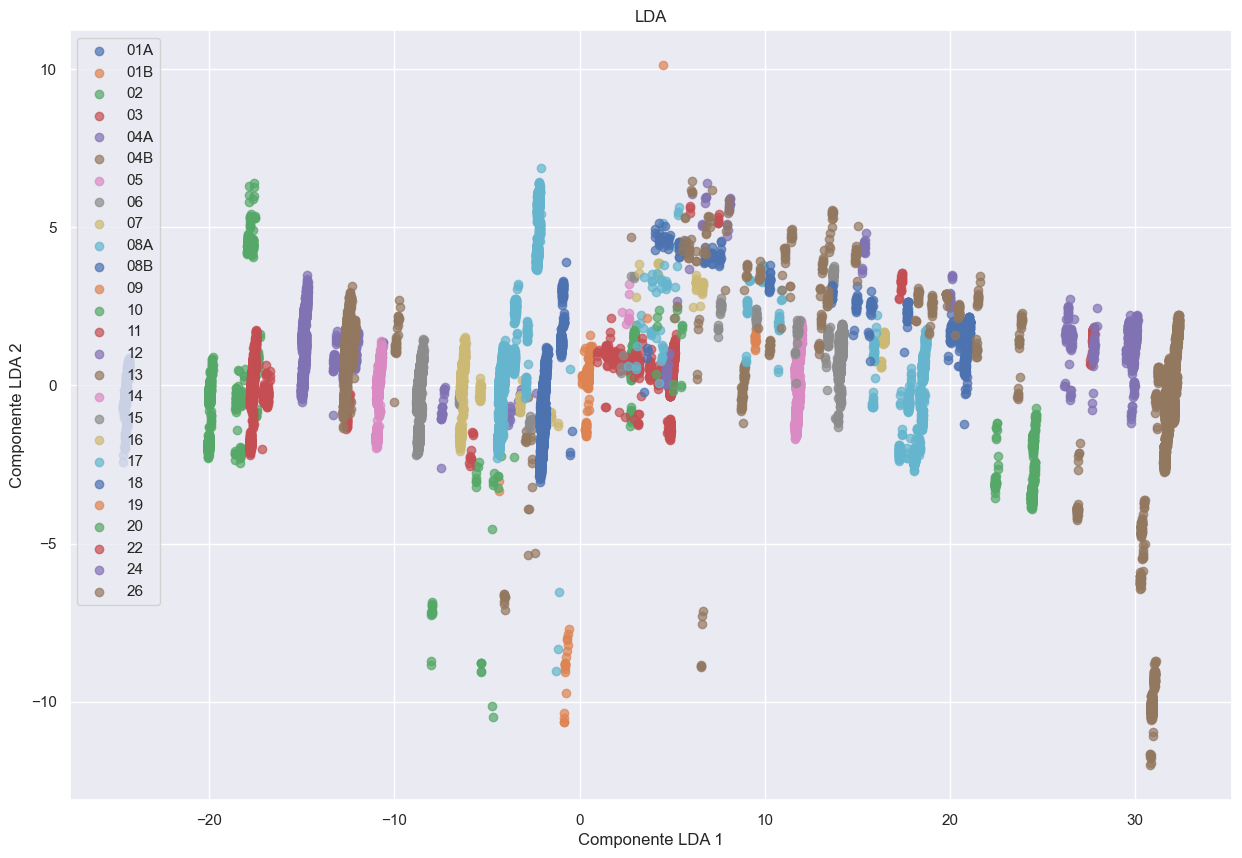

Porcentaje de varianza capturada por cada componente:
[0.99177517 0.00335862]
Porcentaje de varianza acumulada:
[0.99177517 0.99513379]


In [31]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train_inf_mut, y_train)

plt.figure(figsize=(15, 10))
for _, target_name in enumerate(target_names):
    plt.scatter(X_train_lda[y_train == target_name, 0], X_train_lda[y_train == target_name, 1], label=target_name, alpha=0.7)
plt.xlabel("Componente LDA 1")
plt.ylabel("Componente LDA 2")
plt.legend()
plt.title("LDA")
plt.show()

print(f"Porcentaje de varianza capturada por cada componente:\n{lda.explained_variance_ratio_}")
print(f"Porcentaje de varianza acumulada:\n{np.cumsum(lda.explained_variance_ratio_)}")

# Aplicamos a los datos de test
X_test_lda = lda.transform(X_test_inf_mut)


In [32]:
from sklearn.metrics import silhouette_score
# Calculamos solo sobre el 10% porque demora mucho si usamos todas las muestras
sil_score = silhouette_score(X_train_lda, y_train, sample_size=int(len(X_train_lda)*0.1), random_state=42)
print(f"Silhouette Score: {sil_score:.2f}")

Silhouette Score: 0.68


Con este valor Silhouette y lo visualizado en el gráfico anterior podemos decir que si bien hay algo de solapamiento entre clases, tienen un buen nivel de separación.  
Tan solo con 1 componente esta capturando el 99% de varianza.

Visualizamos como quedaron los datos con LDA

In [33]:
print(f"Dataset original:")
display(X_train.head(5))
X_train_lda2 = pd.DataFrame(X_train_lda, columns=['LD1', 'LD2'], index=X_train.index)
X_train_lda2['FBI Code'] = y_train

print(f"Dataset reducido:")
display(X_train_lda2.head(5))


Dataset original:


,Date,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,Latitude,Longitude,Hour,Day Of Week,Day,Month,Season
ID,,,,,,,,,,,,,,,,,,
13429144,2024-04-14 14:00:00,0460,BATTERY,SIMPLE,AIRPORT EXTERIOR - SECURE AREA,False,False,1655,16,41,76,41.974862,-87.890372,14,6,14,4,Primavera
13595894,2024-09-12 20:00:00,0520,ASSAULT,AGGRAVATED - KNIFE / CUTTING INSTRUMENT,STREET,False,False,1235,12,25,31,41.856603,-87.655479,20,3,12,9,Verano
13680379,2024-12-02 18:19:00,5002,OTHER OFFENSE,OTHER VEHICLE OFFENSE,STREET,False,False,924,9,15,61,41.813589,-87.666329,18,0,2,12,Otoño
13522434,2024-06-28 20:30:00,0810,THEFT,OVER $500,RESIDENCE - GARAGE,False,False,2433,24,48,77,41.993125,-87.655482,20,4,28,6,Verano
13353509,2024-01-30 18:48:00,041A,BATTERY,AGGRAVATED - HANDGUN,STREET,False,False,1131,11,24,25,41.874123,-87.743783,18,1,30,1,Invierno


Dataset reducido:


,LD1,LD2,FBI Code
ID,,,
13429144,-1.976439,-0.819012,08B
13595894,-14.901771,1.740814,04A
13680379,31.648357,-0.558923,26
13522434,-8.671783,-0.227752,06
13353509,-12.642361,1.045502,04B


Ventajas del dataset reducido:
 * Mejora el rendimiento de los modelos.
 * Ayuda a los modelos a generalizar mejor los datos y a evitar el sobreajuste (overfitting).
 * Reducción de tiempo y costo computacional.
 * Disminución de espacio de almacenamiento (debido a menor cantidad de features).
 * En ciertos casos facilita la visualización de los datos (en 2 o 3 dimensiones).
 * Eliminación de ruido y redundancia, al identificar y descartar características que no contribuyen significativamente al modelo.

Desventajas:
 * Posible pérdida de información.
 * Perdida de interpretabilidad.
